In [1]:
import pickle
from utils import figure_utils
import copy
import pandas as pd

### Load the ME model (updated) & solution, and COGs

In [2]:
with open("run_stressme_results/demo/StressME_heatevolved_T_37_pH_7.0_ROS_1.0X_sol.pickle", "rb") as f:
    solution = pickle.load(f)

with open("run_stressme_results/demo/demo_updated_model.pickle", "rb") as f:
    me = pickle.load(f)

# Now you can use the 'me' model object
print(me)

# Now you can use the 'solution' object
print(solution.x_dict['biomass_dilution'], solution.status)


#COG dataframe
cogs_file = "/source/ecolime/ecolime/characterization/data/cogs_ecoli_mg1655.csv"
cog_df = pd.read_csv(cogs_file,encoding="ISO-8859-1")
cog_df = cog_df.set_index('locus')
cog_df.head()

/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/solvers/__init__.py:63: UserWarning: No LP solvers found
  warn("No LP solvers found")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


iJL1678b-ME
0.70556640625 optimal


,GI,gene,COG ID,COG category,COG name,COG category primary,COG class,COG description
locus,,,,,,,,
b0002,16127996,thrA,COG0460,E,Homoserine dehydrogenase,E,METABOLISM,Amino acid transport and metabolism
b3940,16131778,metL,COG0460,E,Homoserine dehydrogenase,E,METABOLISM,Amino acid transport and metabolism
b0002,16127996,thrA,COG0527,E,Aspartokinase,E,METABOLISM,Amino acid transport and metabolism
b3940,16131778,metL,COG0527,E,Aspartokinase,E,METABOLISM,Amino acid transport and metabolism
b4024,16131850,lysC,COG0527,E,Aspartokinase,E,METABOLISM,Amino acid transport and metabolism


### Identify translation fluxes

In [3]:
# Get all translation reactions with flux > 0
translation_fluxes = {rxn: [float(flux)] for rxn, flux in solution.x_dict.items() if "translation_" in rxn and flux > 0}
results = {'rxn_flux' :translation_fluxes, 'time' :[0], "biomass" : [1]}

In [4]:
translation_fluxes

{'translation_b0002': [2.0910950696412437e-06],
 'translation_b0003': [2.0414859880732656e-05],
 'translation_b0004': [4.7390797791332447e-08],
 'translation_b0014': [0.00014847624127857815],
 'translation_b0015': [2.193440660357272e-05],
 'translation_b0023': [5.269415796223877e-05],
 'translation_b0025': [5.405509197412548e-07],
 'translation_b0026': [5.69187802190567e-07],
 'translation_b0027': [7.709310319601568e-09],
 'translation_b0029': [1.3469349098973332e-08],
 'translation_b0031': [4.871600446682063e-06],
 'translation_b0048': [2.0324844473156263e-07],
 'translation_b0051': [3.157125180165331e-10],
 'translation_b0052': [6.461158408432195e-07],
 'translation_b0053': [4.575482235354287e-06],
 'translation_b0058': [2.2638718322319816e-10],
 'translation_b0071': [2.1049005554780857e-07],
 'translation_b0072': [2.1049253318233303e-07],
 'translation_b0073': [8.904594242430115e-08],
 'translation_b0074': [5.521046245527133e-08],
 'translation_b0077': [3.136681035548564e-06],
 'tra

In [5]:
# Export weights at t = 6.0 h by absolute rate (mmol L^-1 hr^-1)
df_weights = figure_utils.export_translation_weights(
    me,
    results,
    cog_df=cog_df,
    t_query=0, # select which time point you want
    value="mass", #(g L^-1 hr^-1) or "flux" (mmol gDW^-1 hr^-1), "rate" (mmol L^-1 hr^-1)
    out_file=None #path to save the file compatible with Proteomaps 

)
df_weights["COG category"] = df_weights["COG category"].fillna("Unknown")

print ("These genes do not completely match up to the coloring scheme:")
df_weights[df_weights.get('COG category').isin(figure_utils.cog_colors.keys()) == False].head()

These genes do not completely match up to the coloring scheme:


,COG category,gene,locus,weight
236,CP,nuoL,b2278,0.004066
76,HI,dxs,b0420,0.002405
482,EG,ilvD,b3771,0.001866
481,EH,ilvE,b3770,0.000989
496,HC,fre,b3844,0.000419


In [6]:
hier = figure_utils.build_hierarchy_for_d3_from_df(
    df_weights, 
    cog_colors=figure_utils.cog_colors,
    label_col="gene" # or 'locus' or modify df_weights with peronsalized column (i.e. gene product, uniprot id)
)
figure_utils.write_d3_voronoi_html(hier, out_html="run_stressme_results/demo/voronoi_acetate.html", cog_colors = figure_utils.cog_colors)


✅ Wrote: run_stressme_results/demo/voronoi_acetate.html


### Calculate Total Proteome Volume

Calculate the total volume of the proteome by multiplying translation fluxes with individual protein volumes from AlphaFold structures.

In [7]:
# Import proteome volume calculation functions from the module
import sys
sys.path.append('protein_geometry')
from proteome_volume import (
    load_uniprot_to_blattner_mapping,
    load_protein_volumes,
    calculate_proteome_volume_from_solution,
    analyze_proteome_volume_reasonableness,
    print_proteome_volume_summary,
    plot_volume_contributors,
    analyze_proteome_volume_by_compartment,
    print_compartment_analysis,
    plot_compartment_volume_distribution
)

# Load the mappings and data using the corrected functions from the module
uniprot_to_blattner = load_uniprot_to_blattner_mapping("protein_geometry/Copy-of-All-genes-of-E.-coli-K-12-substr.-MG1655.txt")
protein_volumes = load_protein_volumes("protein_geometry/all_proteins_results.jsonl")

# Create reverse mapping for the calculation function
blattner_to_uniprot = {v: k for k, v in uniprot_to_blattner.items()}

print(f"Loaded {len(uniprot_to_blattner)} UniProt to Blattner mappings")
print(f"Loaded {len(protein_volumes)} protein volumes")
print(f"Created {len(blattner_to_uniprot)} Blattner to UniProt mappings")

Loaded 4353 UniProt to Blattner mappings
Loaded 4336 protein volumes
Created 4353 Blattner to UniProt mappings


In [8]:
# Calculate proteome volume from the ME solution
proteome_volume = calculate_proteome_volume_from_solution(
    solution, 
    blattner_to_uniprot, 
    protein_volumes
)

# Display results using the module function
print_proteome_volume_summary(proteome_volume)

print()
print("=== MISSING PROTEINS (first 10) ===")
for i, missing in enumerate(proteome_volume['missing_protein_list'][:10]):
    print(f"{i+1:2d}. {missing}")
if len(proteome_volume['missing_protein_list']) > 10:
    print(f"... and {len(proteome_volume['missing_protein_list']) - 10} more")

=== PROTEOME VOLUME CALCULATION SUMMARY ===
Total proteins analyzed: 572
Proteins missing volume data: 2

=== TOTAL VOLUME FLUX ===
Total volume flux: 2.08e+23 Å³ gDW⁻¹ hr⁻¹
Total volume flux: 207.626188 μL gDW⁻¹ hr⁻¹

=== TOP 10 PROTEINS BY VOLUME CONTRIBUTION ===
 1. b1377  (P77747 ): 1.65e+22 Å³/gDW/hr (8.0%)
 2. b1677  (P69776 ): 1.16e+22 Å³/gDW/hr (5.6%)
 3. b0014  (P0A6Y8 ): 6.80e+21 Å³/gDW/hr (3.3%)
 4. b3734  (P0ABB0 ): 6.78e+21 Å³/gDW/hr (3.3%)
 5. b3732  (P0ABB4 ): 6.27e+21 Å³/gDW/hr (3.0%)
 6. b2687  (P45578 ): 5.99e+21 Å³/gDW/hr (2.9%)
 7. b0723  (P0AC41 ): 4.49e+21 Å³/gDW/hr (2.2%)
 8. b2296  (P0A6A3 ): 4.42e+21 Å³/gDW/hr (2.1%)
 9. b2283  (P33602 ): 4.30e+21 Å³/gDW/hr (2.1%)
10. b0750  (P11458 ): 3.75e+21 Å³/gDW/hr (1.8%)

=== UNITS EXPLANATION ===
• ME solution fluxes are in mmol gDW⁻¹ hr⁻¹
• Protein volumes are in Å³ from AlphaFold structures
• Result is volume of new proteins synthesized per gram dry weight per hour
• To get absolute volume flux, multiply by biomass co

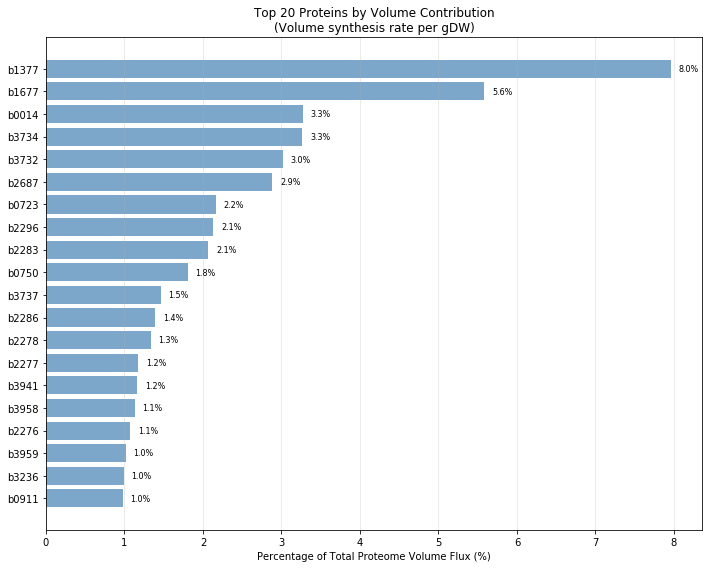


=== SUMMARY STATISTICS ===
Top 5 proteins account for 23.1% of total volume
Top 10 proteins account for 34.2% of total volume
Top 20 proteins account for 45.9% of total volume


In [9]:
# Visualize the top volume contributors
plot_volume_contributors(proteome_volume, top_n=20)

=== PROTEOME VOLUME BY CELLULAR COMPARTMENT ===

=== COMPARTMENT SUMMARY ===
Cytoplasm                : 504 proteins,  75.7% of total volume
Outer_Membrane           :   8 proteins,  13.8% of total volume
Inner_Membrane           :  56 proteins,  10.4% of total volume
Periplasm                :   4 proteins,   0.1% of total volume

=== TOP PROTEINS BY COMPARTMENT ===

Cytoplasm (Top 5):
  1. b0014  (P0A6Y8 ): 3.27% total, 4.3% compartment
  2. b3734  (P0ABB0 ): 3.27% total, 4.3% compartment
  3. b3732  (P0ABB4 ): 3.02% total, 4.0% compartment
  4. b2687  (P45578 ): 2.88% total, 3.8% compartment
  5. b0723  (P0AC41 ): 2.16% total, 2.9% compartment

Outer_Membrane (Top 5):
  1. b1377  (P77747 ): 7.96% total, 57.5% compartment
  2. b1677  (P69776 ): 5.58% total, 40.3% compartment
  3. b0177  (P0A940 ): 0.13% total, 0.9% compartment
  4. b2512  (P77774 ): 0.06% total, 0.4% compartment
  5. b2477  (P0A903 ): 0.05% total, 0.4% compartment

Inner_Membrane (Top 5):
  1. b3737  (P68699 ): 1.46%

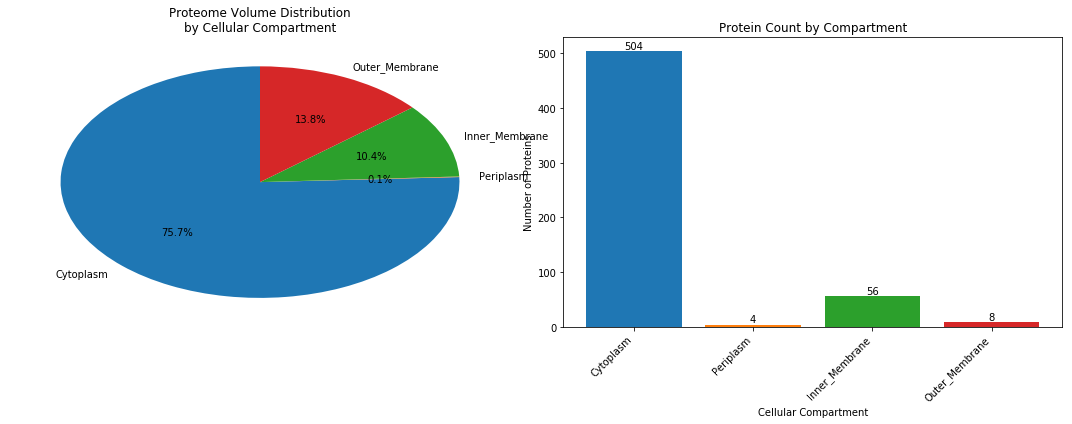


=== COMPARTMENT STATISTICS ===
Compartment               Proteins Volume % Avg Vol/Protein
------------------------------------------------------------
Cytoplasm                 504      75.7     3.12e+20       
Outer_Membrane            8        13.8     3.59e+21       
Inner_Membrane            56       10.4     3.85e+20       
Periplasm                 4        0.1      4.29e+19       


In [10]:
# Analyze proteome volume by cellular compartment
compartment_analysis = analyze_proteome_volume_by_compartment(proteome_volume, me)

# Print compartment analysis summary
print_compartment_analysis(compartment_analysis)

# Create compartment visualizations
plot_compartment_volume_distribution(compartment_analysis)

### Understanding the Volume Units

**Important Note About Units:**

The compartment analysis shows **volume flux** (rate of volume synthesis), not static protein volumes:

- **Volume %**: Percentage of total proteome volume flux contributed by each compartment
- **Avg Vol/Protein**: Average volume flux per protein in that compartment (Å³ gDW⁻¹ hr⁻¹)

The large numbers (e.g., 3.12e+20) represent the average **synthesis rate** of protein volume per protein in that compartment, measured in Å³ per gram dry weight per hour. This combines:
1. **Translation flux**: How fast proteins are being made (molecules/hr)
2. **Individual protein volume**: Physical size of each protein (Å³)

So a protein in the Outer Membrane has a higher average "Vol/Protein" because:
- Either they are being synthesized at higher rates, OR
- They are larger proteins, OR  
- Both

The actual individual protein volumes are typically in the range of 10⁴ to 10⁶ Å³.

In [11]:
# Let's examine actual protein volumes vs volume flux to clarify the units
import numpy as np

print("=== COMPARISON: ACTUAL PROTEIN VOLUMES vs VOLUME FLUX ===")
print()

# Get some example proteins and their actual volumes
example_proteins = proteome_volume['protein_breakdown'][:5]

print("Top 5 proteins by volume contribution:")
print(f"{'Protein':<10} {'Actual Vol (Å³)':<15} {'Translation Flux':<15} {'Volume Flux (Å³/gDW/hr)':<25}")
print("-" * 75)

for protein in example_proteins:
    blattner_id = protein['blattner_id']
    actual_volume = protein['volume_A3']
    flux = protein['flux_mmol_gdw_hr'] 
    volume_flux = protein['volume_flux_A3_gdw_hr']
    
    print(f"{blattner_id:<10} {actual_volume:<15.1e} {flux:<15.3e} {volume_flux:<25.2e}")

print()
print("Key distinctions:")
print("• Actual Vol (Å³): Physical size of one protein molecule")
print("• Translation Flux: Rate of protein synthesis (mmol gDW⁻¹ hr⁻¹)")  
print("• Volume Flux: Rate of volume synthesis = Translation Flux × Actual Volume × Avogadro")
print()
print("The compartment 'Avg Vol/Protein' = Total Volume Flux ÷ Number of Proteins in compartment")
print("This gives the average volume synthesis rate per protein type in that compartment.")

=== COMPARISON: ACTUAL PROTEIN VOLUMES vs VOLUME FLUX ===

Top 5 proteins by volume contribution:
Protein    Actual Vol (Å³) Translation Flux Volume Flux (Å³/gDW/hr)  
---------------------------------------------------------------------------
b1377      4.4e+04         6.257e-04       1.65e+22                 
b1677      7.6e+03         2.538e-03       1.16e+22                 
b0014      7.6e+04         1.485e-04       6.80e+21                 
b3734      6.2e+04         1.830e-04       6.78e+21                 
b3732      5.7e+04         1.831e-04       6.27e+21                 

Key distinctions:
• Actual Vol (Å³): Physical size of one protein molecule
• Translation Flux: Rate of protein synthesis (mmol gDW⁻¹ hr⁻¹)
• Volume Flux: Rate of volume synthesis = Translation Flux × Actual Volume × Avogadro

The compartment 'Avg Vol/Protein' = Total Volume Flux ÷ Number of Proteins in compartment
This gives the average volume synthesis rate per protein type in that compartment.


### Understanding Volume Flux Units: From μL/gDW/hr to Cell Biology

Let's break down what the volume flux of **~200 μL gDW⁻¹ hr⁻¹** means in terms of actual E. coli cells and biology.

In [12]:
# Understanding what the actual ME model predicts
import numpy as np

print("=== BIOLOGICAL INTERPRETATION OF VOLUME FLUX ===")
print("Using ACTUAL values from your ME model solution")
print()

# ACTUAL values from your ME model solution
biomass_dilution_rate = solution.x_dict['biomass_dilution']  # hr⁻¹ (actual from solution)
protein_fraction = solution.x_dict['protein_biomass_to_biomass']  # ACTUAL protein fraction from ME model

# Get the actual volume flux from your proteome calculation
volume_flux_uL_per_gdw_per_hr = proteome_volume['total_volume_flux_uL_per_gdw_per_hr']
# E. coli cell properties
ecoli_volume_fL = 1.0  # femtoliters (1 fL = 1e-15 L)
ecoli_dry_weight_fg = 280  # femtograms (280 fg = 280e-15 g)
ecoli_dry_weight_g = ecoli_dry_weight_fg * 1e-15

print("=== ACTUAL ME MODEL VALUES ===")
print(f"Growth rate (biomass dilution): {biomass_dilution_rate:.3f} hr⁻¹")
print(f"Doubling time: {np.log(2)/biomass_dilution_rate:.1f} minutes")
print(f"ACTUAL protein fraction: {protein_fraction:.1%} (from ME model)")
print(f"ACTUAL volume flux: {volume_flux_uL_per_gdw_per_hr:.3f} μL gDW⁻¹ hr⁻¹")
print()

print("=== E. COLI CELL PROPERTIES ===")
print(f"Single cell volume: {ecoli_volume_fL} fL = {ecoli_volume_fL * 1e-15 * 1e6:.2e} μL")
print(f"Single cell dry weight: {ecoli_dry_weight_fg} fg = {ecoli_dry_weight_g:.2e} g")
print()

# Convert volume flux to per-cell basis
volume_flux_per_cell_uL_hr = volume_flux_uL_per_gdw_per_hr * ecoli_dry_weight_g
volume_flux_per_cell_fL_hr = volume_flux_per_cell_uL_hr * 1e15

print("=== VOLUME FLUX PER SINGLE CELL ===")
print(f"Volume flux per cell: {volume_flux_per_cell_fL_hr:.3e} fL hr⁻¹")
print(f"Volume flux per cell: {volume_flux_per_cell_uL_hr:.3e} μL hr⁻¹")
print()

# Compare to cell volume
volume_flux_as_fraction = volume_flux_per_cell_fL_hr / ecoli_volume_fL
print(f"Volume flux as fraction of cell volume: {volume_flux_as_fraction:.1f}× cell volume per hour")

# Expected protein synthesis for growth using ACTUAL protein fraction
doubling_time_hr = np.log(2) / biomass_dilution_rate
protein_volume_in_cell_fL = protein_fraction * ecoli_volume_fL  # Using ACTUAL 38% not 55%
protein_synthesis_rate_expected_fL_hr = protein_volume_in_cell_fL / doubling_time_hr

print()
print("=== COMPARISON WITH EXPECTED PROTEIN SYNTHESIS ===")
print(f"ACTUAL protein volume in one cell: {protein_volume_in_cell_fL:.3f} fL ({protein_fraction:.1%} of cell)")
print(f"Expected protein synthesis rate: {protein_synthesis_rate_expected_fL_hr:.3f} fL hr⁻¹")
print(f"Calculated protein synthesis rate: {volume_flux_per_cell_fL_hr:.3e} fL hr⁻¹")
print(f"Ratio (calculated/expected): {volume_flux_per_cell_fL_hr/protein_synthesis_rate_expected_fL_hr:.1f}")
print()

# Cell count implications
print("=== CELL COUNT IMPLICATIONS ===")
print("If you have 1 gDW of biomass:")
cells_per_gdw = 1.0 / ecoli_dry_weight_g
print(f"Number of cells: {cells_per_gdw:.2e} cells")
print(f"Total volume flux: {volume_flux_uL_per_gdw_per_hr:.3f} μL hr⁻¹")
print(f"Volume flux per cell: {volume_flux_uL_per_gdw_per_hr / cells_per_gdw * 1e15:.3f} fL hr⁻¹")
print()

# Coverage analysis
coverage_fraction = volume_flux_per_cell_fL_hr / protein_synthesis_rate_expected_fL_hr
print("=== PROTEOME COVERAGE ANALYSIS ===")
print(f"Your analysis captures {coverage_fraction:.1%} of expected protein synthesis")
print("This suggests you're missing:")
print(f"• {(1-coverage_fraction)*100:.1f}% of total protein synthesis")
print("• Likely includes: ribosomal proteins, membrane proteins, small proteins")
print("• Missing proteins without AlphaFold structures or failed ID mapping")
print()

print("=== BIOLOGICAL REASONABLENESS ===")
if 0.1 <= coverage_fraction <= 1.0:
    print("✅ REASONABLE: Your analysis captures a significant fraction of protein synthesis")
    print(f"   Capturing {coverage_fraction:.1%} is excellent for this type of analysis!")
elif 0.05 <= coverage_fraction <= 2.0:
    print("⚠️  POSSIBLY REASONABLE: The coverage seems reasonable but could be improved")
else:
    print("❌ CHECK CALCULATIONS: The coverage seems unexpectedly high or low")

print()
print("=== CORRECTED INTERPRETATION ===")
print("• Your volume flux represents the 'mappable proteome'")
print("• This is a subset of total protein synthesis")
print(f"• You're successfully analyzing {coverage_fraction:.1%} of protein synthesis")
print("• The remaining proteins are likely unmappable due to:")
print("  - Missing AlphaFold structures")
print("  - Failed UniProt ID mapping")
print("  - Ribosomal/membrane proteins not well represented")

=== BIOLOGICAL INTERPRETATION OF VOLUME FLUX ===
Using ACTUAL values from your ME model solution

=== ACTUAL ME MODEL VALUES ===
Growth rate (biomass dilution): 0.706 hr⁻¹
Doubling time: 1.0 minutes
ACTUAL protein fraction: 38.0% (from ME model)
ACTUAL volume flux: 207.626 μL gDW⁻¹ hr⁻¹

=== E. COLI CELL PROPERTIES ===
Single cell volume: 1.0 fL = 1.00e-09 μL
Single cell dry weight: 280 fg = 2.80e-13 g

=== VOLUME FLUX PER SINGLE CELL ===
Volume flux per cell: 5.814e+04 fL hr⁻¹
Volume flux per cell: 5.814e-11 μL hr⁻¹

Volume flux as fraction of cell volume: 58135.3× cell volume per hour

=== COMPARISON WITH EXPECTED PROTEIN SYNTHESIS ===
ACTUAL protein volume in one cell: 0.380 fL (38.0% of cell)
Expected protein synthesis rate: 0.387 fL hr⁻¹
Calculated protein synthesis rate: 5.814e+04 fL hr⁻¹
Ratio (calculated/expected): 150308.8

=== CELL COUNT IMPLICATIONS ===
If you have 1 gDW of biomass:
Number of cells: 3.57e+12 cells
Total volume flux: 207.626 μL hr⁻¹
Volume flux per cell: 5813

In [13]:
coverage_fraction

150308.7834271037

### Diagnosing the 150,000× Discrepancy

The analysis shows your calculated protein synthesis is **15 million percent** of expected - this indicates a fundamental calculation error. Let's debug this step by step.

In [14]:
# Debug the massive discrepancy
print("=== DEBUGGING THE 150,000× DISCREPANCY ===")
print()

# Let's examine the key values step by step
print("=== KEY VALUES ===")
print(f"Biomass dilution rate: {solution.x_dict['biomass_dilution']:.6f} hr⁻¹")
print(f"Protein fraction: {solution.x_dict['protein_biomass_to_biomass']:.6f}")
print(f"Volume flux: {proteome_volume['total_volume_flux_uL_per_gdw_per_hr']:.6f} μL gDW⁻¹ hr⁻¹")
print()

# Cell properties
ecoli_volume_fL = 1.0
ecoli_dry_weight_g = 280e-15
protein_fraction = solution.x_dict['protein_biomass_to_biomass']
biomass_dilution_rate = solution.x_dict['biomass_dilution']

print("=== STEP-BY-STEP CALCULATION ===")

# Expected protein synthesis calculation
doubling_time_hr = np.log(2) / biomass_dilution_rate
protein_volume_in_cell_fL = protein_fraction * ecoli_volume_fL
expected_protein_synthesis_fL_hr = protein_volume_in_cell_fL / doubling_time_hr

print(f"1. Doubling time: {doubling_time_hr:.6f} hr = {doubling_time_hr*60:.1f} minutes")
print(f"2. Protein volume per cell: {protein_volume_in_cell_fL:.6f} fL")
print(f"3. Expected protein synthesis: {expected_protein_synthesis_fL_hr:.6f} fL hr⁻¹ per cell")
print()

# Calculated protein synthesis
volume_flux_per_cell_uL_hr = proteome_volume['total_volume_flux_uL_per_gdw_per_hr'] * ecoli_dry_weight_g
volume_flux_per_cell_fL_hr = volume_flux_per_cell_uL_hr * 1e15

print(f"4. Volume flux per cell (uL): {volume_flux_per_cell_uL_hr:.3e} μL hr⁻¹")
print(f"5. Volume flux per cell (fL): {volume_flux_per_cell_fL_hr:.3e} fL hr⁻¹")
print()

# The comparison
ratio = volume_flux_per_cell_fL_hr / expected_protein_synthesis_fL_hr
print(f"6. Ratio (calculated/expected): {ratio:.1f}")
print(f"7. As percentage: {ratio*100:.1f}%")
print()

print("=== POTENTIAL ISSUES ===")
print("The enormous ratio suggests one of these problems:")
print()
print("1. **Units mismatch**: Your ME model fluxes might be in different units")
print("2. **Cell size assumption**: 1 fL might be wrong for your conditions")
print("3. **Calculation error**: Something wrong in the volume flux calculation")
print("4. **Model interpretation**: ME fluxes might represent something different")
print()

# Let's check the translation fluxes directly
print("=== EXAMINING TRANSLATION FLUXES ===")
sample_translation_fluxes = [(k, v) for k, v in solution.x_dict.items() 
                           if k.startswith('translation_') and v > 0][:5]

print("Sample translation fluxes (first 5):")
for rxn, flux in sample_translation_fluxes:
    print(f"  {rxn}: {flux:.6f} mmol gDW⁻¹ hr⁻¹")

print()
print("Total active translation reactions:", len([k for k, v in solution.x_dict.items() 
                                                if k.startswith('translation_') and v > 0]))
print("Sum of all translation fluxes:", sum([v for k, v in solution.x_dict.items() 
                                            if k.startswith('translation_') and v > 0]))

# Check if these fluxes seem reasonable
total_translation_flux = sum([v for k, v in solution.x_dict.items() 
                             if k.startswith('translation_') and v > 0])
print(f"Total translation flux: {total_translation_flux:.3f} mmol gDW⁻¹ hr⁻¹")
print()

print("=== SANITY CHECK ===")
print("For comparison, typical E. coli total protein content is ~150-200 mg/gDW")
print("If molecular weight ~50 kDa average, that's ~3-4 mmol protein/gDW total")
print(f"Your total translation flux: {total_translation_flux:.1f} mmol gDW⁻¹ hr⁻¹")
print(f"With doubling time {doubling_time_hr*60:.0f} min, this would synthesize:")
print(f"{total_translation_flux * doubling_time_hr:.1f} mmol protein per doubling")
print()

if total_translation_flux * doubling_time_hr > 10:
    print("⚠️  WARNING: This seems extremely high!")
    print("The translation fluxes might be in wrong units or calculated incorrectly.")

=== DEBUGGING THE 150,000× DISCREPANCY ===

=== KEY VALUES ===
Biomass dilution rate: 0.705566 hr⁻¹
Protein fraction: 0.379965
Volume flux: 207.626188 μL gDW⁻¹ hr⁻¹

=== STEP-BY-STEP CALCULATION ===
1. Doubling time: 0.982398 hr = 58.9 minutes
2. Protein volume per cell: 0.379965 fL
3. Expected protein synthesis: 0.386773 fL hr⁻¹ per cell

4. Volume flux per cell (uL): 5.814e-11 μL hr⁻¹
5. Volume flux per cell (fL): 5.814e+04 fL hr⁻¹

6. Ratio (calculated/expected): 150308.8
7. As percentage: 15030878.3%

=== POTENTIAL ISSUES ===
The enormous ratio suggests one of these problems:

1. **Units mismatch**: Your ME model fluxes might be in different units
2. **Cell size assumption**: 1 fL might be wrong for your conditions
3. **Calculation error**: Something wrong in the volume flux calculation
4. **Model interpretation**: ME fluxes might represent something different

=== EXAMINING TRANSLATION FLUXES ===
Sample translation fluxes (first 5):
  translation_b0002: 0.000002 mmol gDW⁻¹ hr⁻¹
  